In [1]:
import data.generate_data as gd
import data.generate_sers_bg as gsb
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
mapsize = [30, 30]
num_hotspot = 2
Nw = 110 
concentration = 0.5 
sbr = 1 / 100 * (np.exp(concentration) - 1)
seed_use = 1111
seed_intensity_use = 1111
gamma_avg = 3 
num_peak = 2
fix_hotspot_intensity = False 
hotspot_scale = 5

np.random.seed(seed_use)


### Parameters for generating the Raman signal, background spectrum, and noise spectrum 

In [3]:
c = np.array([np.random.uniform(20,  Nw / 2 - 7), 
              np.random.uniform(Nw / 2+7,  Nw - 20)]) # The center peak locations
gamma = np.random.normal(gamma_avg, 1, size=num_peak) # Full-width-at-half-maximum (FWHM)
eta = np.random.rand(num_peak)  # The ratio between Lorentzian and Gaussian distribution 


In [4]:
data_obj = gd.SERSGeneratorMore(mapsize, num_hotspot, Nw, sbr, concentration, 0.2, seed_use, 
                                seed_intensity_use, c=c, gamma=gamma, eta=eta, fix_hotspot_intensity=False, 
                                hotspot_size=hotspot_scale)

### Parameters for generating the contaminants 

In [5]:
# Center peak location, FWHM, ratio between Lorentzian distribution and gaussian distribution for contaminants
c_contaminant = np.random.uniform(20, Nw - 20, [1])
gamma_contaminate = np.random.normal(4, 1, [1])
eta_contaminate = np.random.rand(1)
intensity_contaminate = abs(np.random.normal(sbr, 0.1))
contaminant_parameters = [c_contaminant, gamma_contaminate, eta_contaminate, intensity_contaminate]

### Generate SERS maps
- Generate the base background and background maps 
- Generate the hotspot maps and the pseudo-vogit profile
- If contaminants exist, generate the contaminant maps and contaminant spectrum 
- Generate the noise spectra 
- Combine everything together 

#### 1. Check the background

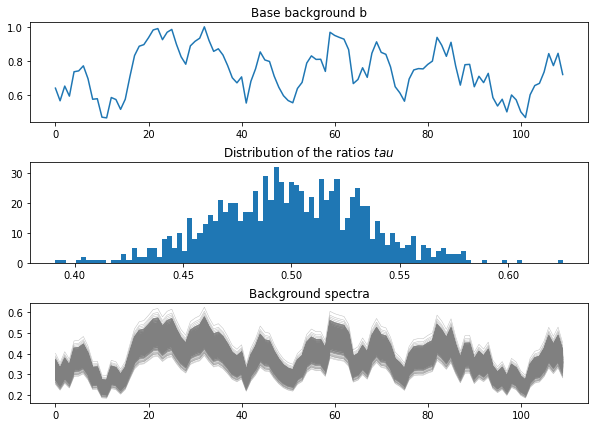

In [6]:
np.random.seed(seed_use)
BB, base_background, background_ratio = data_obj.simulate_background(np.arange(Nw), "ar", [0.2, 0.92])
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(311)
ax.plot(np.arange(Nw), base_background[0])
ax.set_title("Base background b")
ax = fig.add_subplot(312)
ax.hist(background_ratio[:, 0], bins=100)
ax.set_title("Distribution of the ratios " + r'$tau$')
ax = fig.add_subplot(313)
for v in BB:
    ax.plot(np.arange(Nw), v, alpha=0.5, lw=0.5, color='gray')
ax.set_title("Background spectra")
plt.subplots_adjust(hspace=0.4)


#### 2. Check the hotspot maps, the pseudo-vogit profile, Raman signal

The size of the hotspot [6.59136651 7.13285205]
The intensities of the hotspots [0.50955492 0.59250037]


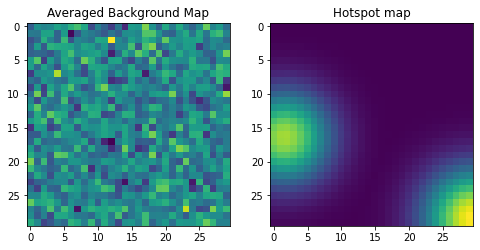

In [7]:
D, mu, r, A = data_obj.simulate_hotspot()
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(121)
ax.imshow(np.reshape(np.mean(BB, axis=-1), mapsize))
ax.set_title("Averaged Background Map")
ax = fig.add_subplot(122)
ax.imshow(np.reshape(D, mapsize))
ax.set_title("Hotspot map")
print("The size of the hotspot", r)
print("The intensities of the hotspots", np.reshape(A, [-1]))


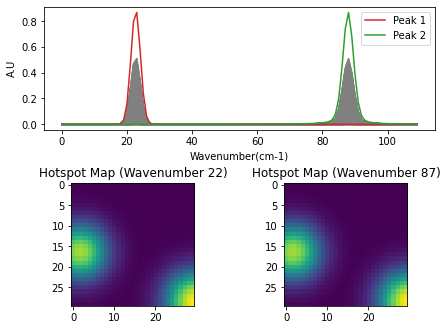

In [8]:
DD, Vp, amplitude = data_obj.simulate_signal(D, BB)
fig = plt.figure(figsize=(7, 5.5))
ax = fig.add_subplot(211)
for v in DD:
    ax.plot(np.arange(Nw), v, color='gray')
ax.plot(np.arange(Nw), Vp[0] * amplitude, color='tab:red', label="Peak 1")
ax.plot(np.arange(Nw), Vp[1] * amplitude, color='tab:green', label="Peak 2")
ax.legend(loc='best')
ax.set_xlabel("Wavenumber(cm-1)")
ax.set_ylabel("A.U")

ax = fig.add_subplot(223)
ax.imshow(np.reshape(DD[:, int(c[0])], mapsize))
ax.set_title("Hotspot Map (Wavenumber %d)" % c[0])
ax = fig.add_subplot(224)
ax.imshow(np.reshape(DD[:, int(c[1])], mapsize))
ax.set_title("Hotspot Map (Wavenumber %d)" % c[1])
plt.subplots_adjust(hspace=0.43)

#### 3. Check the contaminants

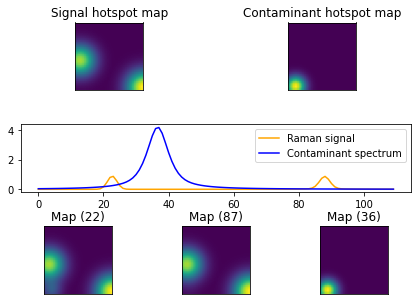

In [9]:
D_contaminate, mu_contaminate, r_contaminate, s_contaminate = data_obj.simulate_contaminate_hotspot([])
DD_contaminate, V_contaminant, A_con = data_obj.add_containminate(D_contaminate, BB, 
                                                  contaminant_parameters[0], 
                                                  contaminant_parameters[1], 
                                                  contaminant_parameters[2], 
                                                  contaminant_parameters[3])
amplitude_contaminant = A_con[1, 0] / D_contaminate[1] 
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(321)
ax.imshow(np.reshape(np.mean(DD, axis=-1), mapsize))
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Signal hotspot map")
ax = fig.add_subplot(322)
ax.imshow(np.reshape(D_contaminate, mapsize))
ax.set_title("Contaminant hotspot map")
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(312)
ax.plot(np.arange(Nw), np.sum(Vp, axis=0) * amplitude, color='orange', label="Raman signal")
ax.plot(np.arange(Nw), V_contaminant[0] * amplitude_contaminant, color = 'blue', label="Contaminant spectrum")
ax.legend(loc='best')

peak_loc = list(c) + list(c_contaminant)
DD_tot = DD + DD_contaminate 

for i, s_v in enumerate(peak_loc):
    ax = fig.add_subplot(3, 3, 7 + i)
    ax.imshow(np.reshape(DD_tot[:, int(s_v)], mapsize))
    ax.set_title("Map (%d)" % s_v)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0.5)

#### 4. SERS maps = Background + Signal + Contaminants + Noise  (highlight 10 spectra that have highest/lowest intensities at peak locations)

Text(0, 0.5, 'A.U.')

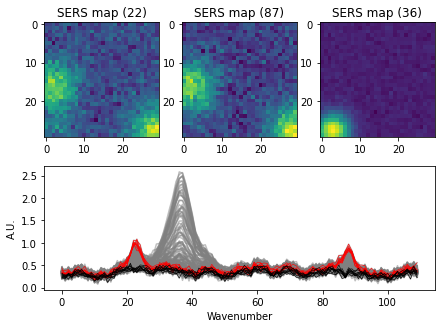

In [10]:
S = BB + DD + DD_contaminate + data_obj.simulate_noise()
fig = plt.figure(figsize=(7, 5))
for i, s_v in enumerate(peak_loc):
    ax = fig.add_subplot(2, 3, i+1)
    ax.imshow(np.reshape(S[:, int(s_v)], mapsize))
    ax.set_title("SERS map (%d)" % (s_v))

ax = fig.add_subplot(2, 1, 2)
for v in S:
    ax.plot(np.arange(Nw), v, color='gray', alpha=0.5)
sort_index = np.argsort(np.sum(S[:, c.astype(np.int32)], axis=-1))
for v in sort_index[-10:]:
    ax.plot(np.arange(Nw), S[v], color='r', lw=0.6)
for v in sort_index[:10]:
    ax.plot(np.arange(Nw), S[v], color='black', lw=0.6)
ax.set_xlabel("Wavenumber")
ax.set_ylabel("A.U.")



### Single function to generate everything

In [11]:
S, DD, BB, signal_stat, contaminant_stat, Vp = data_obj.forward("ar", [0.2, 0.92],
                                                                contaminate_parameter=contaminant_parameters)
[mu_signal, r_signal, s_signal, D_signal, act_sbr, amplitude_act] = signal_stat
[mu_contaminate, r_contaminate, s_contaminate] = contaminant_stat

Text(0, 0.5, 'A.U.')

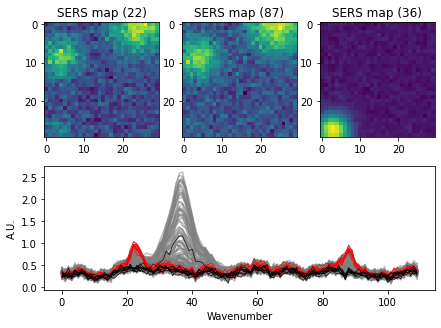

In [12]:
fig = plt.figure(figsize=(7, 5))
for i, s_v in enumerate(peak_loc):
    ax = fig.add_subplot(2, 3, i+1)
    ax.imshow(np.reshape(S[:, int(s_v)], mapsize))
    ax.set_title("SERS map (%d)" % (s_v))

ax = fig.add_subplot(2, 1, 2)
for v in S:
    ax.plot(np.arange(Nw), v, color='gray', alpha=0.5)
sort_index = np.argsort(np.sum(S[:, c.astype(np.int32)], axis=-1))
for v in sort_index[-10:]:
    ax.plot(np.arange(Nw), S[v], color='r', lw=0.6)
for v in sort_index[:10]:
    ax.plot(np.arange(Nw), S[v], color='black', lw=0.6)
ax.set_xlabel("Wavenumber")
ax.set_ylabel("A.U.")
